# 1. 
## (b)

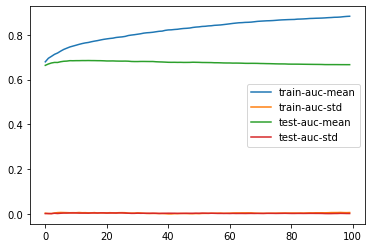

14

In [4]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X = pd.read_csv('marketing.csv')

for col in X.columns:
    if col not in ['age', 'balance']:
        X[col] = X[col].astype("category")

X = pd.get_dummies(X).drop('y_no', axis='columns').rename(columns={'y_yes': 'y'})
y = X.pop('y')

X_tmp, X_final, y_tmp, y_final = train_test_split(X, y, test_size=0.20, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X_tmp, y_tmp, test_size=0.25, random_state=10)

train_dm = xgb.DMatrix(X_train.values, y_train.values)
test_dm = xgb.DMatrix(X_test.values, y_test.values)

param = {'learning_rate': 0.3, 
         'max_depth': 6,
         'objective': 'binary:logistic', 
         'seed': 0, 
         'tree_method': 'gpu_hist', 
         'eval_metric': 'auc', 
        }

# default_bst = xgb.train(param, train_dm)

cvres = xgb.cv(param, train_dm, 100)
cvres.plot()
plt.show()
cvres['test-auc-mean'].argmax()

We started with a parameter set defined as ```param1``` below. There is a way to specify custom eval metric in ```xgboost.cv```. We will be using the prediction error rate in the best 1000 candidates by the model as the eval metric, but we report the opposite, that is 1 minus the prediction error rate, which we name ```best1000```.

The optimal ```best1000``` 0.312 is achieved with 45 trees. 

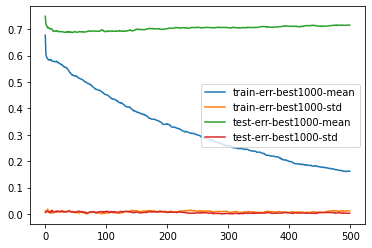

optimal n_estimators:  45
optimal test-best1000:  0.31199999999999994

CPU times: user 15.7 s, sys: 6.86 s, total: 22.5 s
Wall time: 22.5 s


In [57]:
%%time

param1 = {'learning_rate': 0.1, 
          'max_depth': 6,
          'objective': 'binary:logistic', 
          'gamma': 0, 
          'subsample': 0.8, 
          'colsample_bytree': 0.8, 
          'scale_pos_weight': 1, 
          'disable_default_eval_metric': 1, 
          'tree_method': 'gpu_hist', 
          'seed': 0, 
        }

def errBest1000(preds, dtrain):
    labels = dtrain.get_label()
    bestIdxSet = preds.argsort()[-1000:]
    y_select = labels[bestIdxSet]
    return 'err-best1000', 1 - y_select.sum()/1000

cvres = xgb.cv(param1, train_dm, 500, feval=errBest1000)
cvres.plot()
plt.show()

print('optimal n_estimators: ', cvres['test-err-best1000-mean'].argmin())
print('optimal test-best1000: ', 1-cvres['test-err-best1000-mean'].min())
print()

For ```GridSearchCV``` there is a way to specify the scoring (the opposite of eval metric) but it can only be a function of the binary prediction results, not the predicted score. Thus compute ```best1000``` is not possible. We instead use PPV as a proxy, optimizing the probability of a cadidate actually saying yes if he/she is predicted to say yes. 

Tuning ```max_depth``` and ```min_child_weight```, the optimal ```best1000``` improves to 0.316 with 57 trees. 

In [59]:
%%time
from sklearn.model_selection import GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import make_scorer, confusion_matrix

param_grid1 = {
    'max_depth': [4, 6, 8, 10], 
    'min_child_weight': [1, 2, 3, 4, 5], 
}

def ppv(y_true, y_pred):
    # positive predictive value
    tn, fp, fn, tp = confusion_matrix(y_true.values, y_pred).ravel()
    return tp/(tp + fp)

ppv_score = make_scorer(ppv)

grid_search = GridSearchCV(estimator=XGBClassifier(n_estimators=45, **param1), 
                           param_grid=param_grid1, 
                           scoring=ppv_score, cv=5).fit(X_train, y_train)

idx = grid_search.cv_results_['rank_test_score'].argmin()
print('optimal: ', grid_search.cv_results_['params'][idx])
print('best score: ', grid_search.cv_results_['mean_test_score'][idx])
print()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


optimal:  {'max_depth': 10, 'min_child_weight': 1}
best score:  0.44539729238423265

CPU times: user 1min 3s, sys: 36.1 s, total: 1min 39s
Wall time: 1min 39s


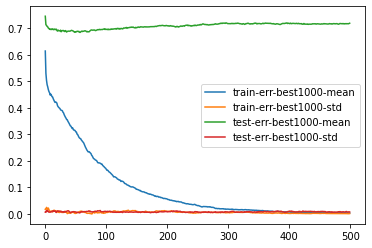

optimal n_estimators:  57
optimal test-best1000:  0.31599999999999995

CPU times: user 36 s, sys: 14.6 s, total: 50.6 s
Wall time: 50.6 s


In [60]:
%%time
param1.update(grid_search.cv_results_['params'][idx])

cvres = xgb.cv(param1, train_dm, 500, feval=errBest1000)
cvres.plot()
plt.show()
print('optimal n_estimators: ', cvres['test-err-best1000-mean'].argmin())
print('optimal test-best1000: ', 1-cvres['test-err-best1000-mean'].min())
print()

The optimal ```max_depth``` was a corner case so we tune ```max_depth``` again alone. As a result the optimal is still 10; using deeper tree will not improve ```best1000```.

In [61]:
%%time

param_grid1 = {
    'max_depth': [8, 10, 12, 14], 
}

grid_search = GridSearchCV(estimator=XGBClassifier(n_estimators=57, **param1), 
                           param_grid=param_grid1, 
                           scoring=ppv_score, cv=5).fit(X_train, y_train)

idx = grid_search.cv_results_['rank_test_score'].argmin()
print('optimal: ', grid_search.cv_results_['params'][idx])
print('best score: ', grid_search.cv_results_['mean_test_score'][idx])
print()

optimal:  {'max_depth': 10}
best score:  0.485117898046261

CPU times: user 39.6 s, sys: 17.8 s, total: 57.5 s
Wall time: 57.4 s


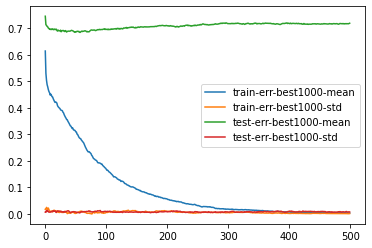

optimal n_estimators:  57
optimal test-best1000:  0.31599999999999995

CPU times: user 35.8 s, sys: 14.9 s, total: 50.7 s
Wall time: 50.7 s


In [62]:
%%time
param1.update(grid_search.cv_results_['params'][idx])

cvres = xgb.cv(param1, train_dm, 500, feval=errBest1000)
cvres.plot()
plt.show()
print('optimal n_estimators: ', cvres['test-err-best1000-mean'].argmin())
print('optimal test-best1000: ', 1-cvres['test-err-best1000-mean'].min())
print()

We then try to tune ```gamma``` and ```reg_alpha``` but the result suggests that the default value 0 is the best for both. 

In [64]:
%%time
param_grid1 = {
    'gamma': [0, 0.2, 0.4, 0.6], 
}

grid_search = GridSearchCV(estimator=XGBClassifier(n_estimators=57, **param1), 
                           param_grid=param_grid1, 
                           scoring=ppv_score, cv=5).fit(X_train, y_train)

idx = grid_search.cv_results_['rank_test_score'].argmin()
print('optimal: ', grid_search.cv_results_['params'][idx])
print('best score: ', grid_search.cv_results_['mean_test_score'][idx])
print()

optimal:  {'gamma': 0}
best score:  0.485117898046261

CPU times: user 31.3 s, sys: 14.8 s, total: 46.1 s
Wall time: 46.1 s


In [69]:
%%time
param_grid1 = {
    'reg_alpha': [0, 1e-5, 1e-2, 0.1, 1, 100]
}

grid_search = GridSearchCV(estimator=XGBClassifier(n_estimators=57, **param1), 
                           param_grid=param_grid1, 
                           scoring=ppv_score, cv=5).fit(X_train, y_train)

idx = grid_search.cv_results_['rank_test_score'].argmin()
print('optimal: ', grid_search.cv_results_['params'][idx])
print('best score: ', grid_search.cv_results_['mean_test_score'][idx])
print()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in long_scalars
  del sys.path[0]


optimal:  {'reg_alpha': 0}
best score:  0.46939683184038683

CPU times: user 1min 21s, sys: 37.3 s, total: 1min 59s
Wall time: 1min 58s


Tuning the tree parameters ```subsample``` and ```colsample_bytree```, the result suggest we had a lucky guess from the beginning. The optimal ```best1000``` remains 0.316 with 57 trees. 

In [67]:
%%time
param_grid1 = {
    'subsample': [0.6, 0.7, 0.8, 0.9], 
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(estimator=XGBClassifier(n_estimators=57, **param1), 
                           param_grid=param_grid1, 
                           scoring=ppv_score, cv=5).fit(X_train, y_train)

idx = grid_search.cv_results_['rank_test_score'].argmin()
print('optimal: ', grid_search.cv_results_['params'][idx])
print('best score: ', grid_search.cv_results_['mean_test_score'][idx])
print()

optimal:  {'colsample_bytree': 0.8, 'subsample': 0.8}
best score:  0.485117898046261

CPU times: user 1min 56s, sys: 53.3 s, total: 2min 49s
Wall time: 2min 49s


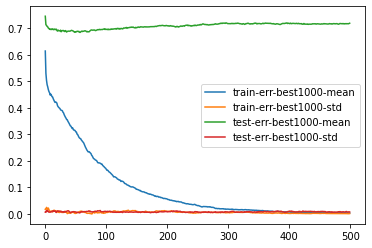

optimal n_estimators:  57
optimal test-best1000:  0.31599999999999995

CPU times: user 36.1 s, sys: 14.7 s, total: 50.8 s
Wall time: 50.8 s


In [68]:
%%time
param1.update(grid_search.cv_results_['params'][idx])

cvres = xgb.cv(param1, train_dm, 500, feval=errBest1000)
cvres.plot()
plt.show()
print('optimal n_estimators: ', cvres['test-err-best1000-mean'].argmin())
print('optimal test-best1000: ', 1-cvres['test-err-best1000-mean'].min())
print()

Finally we lower ```learning_rate``` to allow more trees to contribute in the prediction. The optimal ```best1000``` improves to 0.3223 with 330 trees. 

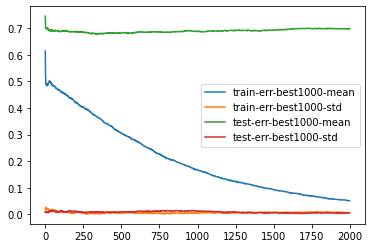

optimal n_estimators:  330
optimal test-best1000:  0.32233333333333336

CPU times: user 2min 20s, sys: 56.4 s, total: 3min 17s
Wall time: 3min 17s


In [70]:
%%time
param1.update({'learning_rate': 0.01})

cvres = xgb.cv(param1, train_dm, 2000, feval=errBest1000)
cvres.plot()
plt.show()
print('optimal n_estimators: ', cvres['test-err-best1000-mean'].argmin())
print('optimal test-best1000: ', 1-cvres['test-err-best1000-mean'].min())
print()

Below is the fine tuned parameter set. 

In [71]:
param1

{'colsample_bytree': 0.8,
 'disable_default_eval_metric': 1,
 'gamma': 0,
 'learning_rate': 0.01,
 'max_depth': 10,
 'min_child_weight': 1,
 'objective': 'binary:logistic',
 'scale_pos_weight': 1,
 'seed': 0,
 'subsample': 0.8,
 'tree_method': 'gpu_hist'}